## Семинар 1 "Полносвязные нейронные сети"

ФИО: 

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [192]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


In [232]:
class Linear:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.normal(0, 1, (input_size + 1, output_size))
        self.dLdw = 0
        self.X = 0
        
        return
    
    def forward(self, X):
        self.X = X
        
        return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.weights)
    
    def backward(self, dLdy):
        dLdx = np.dot(dLdy, self.weights[:len(self.weights) - 1].T)  
        self.dLdw = np.dot(np.vstack((self.X.T, np.ones(self.X.shape[0]))), dLdy)
        return dLdx
    
    def step(self, learning_rate):
        self.weights = self.weights + self.dLdw * learning_rate



### Часть 2: Сигмоида

In [233]:
class Sigmoid:
    def __init__(self):
        
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.X = np.array(X)
        self.sig = 1 / (1 + np.exp(-self.X))
        return self.sig
        
       
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
       
        return dLdy * self.sig * (1 - self.sig)
    
    def step(self, learning_rate):
        pass


### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [314]:
class NLLLoss:
    def __init__(self):
        self.X = np.array([])
        self.y = np.array([])
        pass
    
    def forward(self, X, y):
        self.X = X
        self.y = y
        a = np.log(np.exp(X - X.max(axis=1).reshape((X.shape[0], 1))).sum(axis=1))    
        max_X = X.max(axis=1)
    
            
        return (np.array([X[i][y[i]] for i in range(y.shape[0])]) - max_X - a).sum() / X.shape[0]
    
    def backward(self):
        res = np.exp(self.X - self.X.max(axis=1).reshape((self.X.shape[0], 1)))
        res /= (-1)*res.sum(axis=1).reshape((res.shape[0], 1))
        for i in range(self.y.shape[0]):
            res[i][self.y[i]] += 1
        
        return res / self.X.shape[0]

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [315]:
#### YOUR CODE HERE

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [316]:
class NeuralNetwork:
    def __init__(self, modules):
        self.modules = modules
        pass
    
    def forward(self, X):
        res = X
        for module in self.modules:
            res = module.forward(res)
        return res
    
    def backward(self, dLdy):
        d = dLdy
        for module in self.modules[::-1]:
            d = module.backward(d)
    
    def step(self, learning_rate):
        for module in self.modules:
            module.step(learning_rate)

### Часть 5, обучение на простых данных

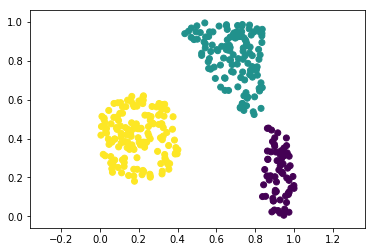

In [317]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [318]:
### YOUR CODE HERE:

In [319]:
m = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
nll = NLLLoss()
nn = NeuralNetwork(m)


In [320]:
import math
from math import exp, log
tl = 0
flag = []

for j in range(5500):
    tl = 0
    ind = 0
    res = nn.forward(X)
    loss = nll.forward(res, y)
    nn.backward(nll.backward())
    nn.step(0.01)
    flag.append(loss)

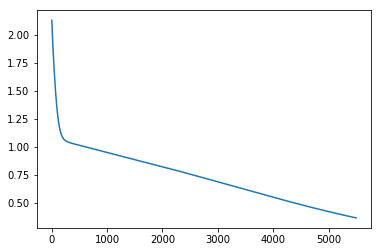

In [321]:
plt.plot(range(5500), -1*np.array(flag))

In [322]:
colors = np.array([0 for i in range(len(y))])

In [323]:
colors = []
res = nn.forward(X)
res = np.exp(res) / np.exp(res).sum()
colors.append([res[i].argmax() for i in range(len(y))])



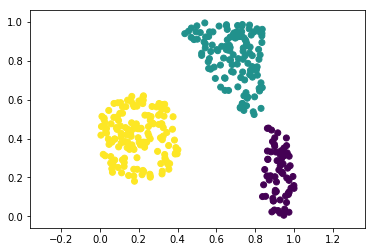

In [324]:
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.axis('equal')
plt.show()

In [325]:
x = np.linspace(-0.2, 1.2, 50)
y = np.linspace(-0.1, 1.1, 50)
xv, yv = np.meshgrid(x, y)

In [327]:
gip = []
for i in range(len(xv)):
    for j in range(len(yv)):
        gip.append([xv[i][j],yv[i][j]])
final = np.array(gip)
final

array([[-0.2       , -0.1       ],
       [-0.17142857, -0.1       ],
       [-0.14285714, -0.1       ],
       ..., 
       [ 1.14285714,  1.1       ],
       [ 1.17142857,  1.1       ],
       [ 1.2       ,  1.1       ]])

In [328]:
result = nn.forward(final)
colors_final = np.array([result[i].argmax() for i in range(len(y)**2)])
colors_final

array([2, 2, 2, ..., 1, 1, 1])

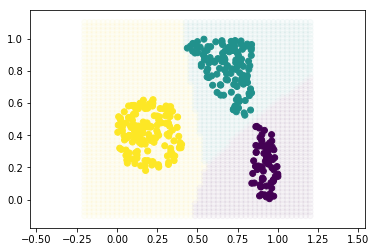

In [329]:
plt.scatter(final[:,0], final[:,1], c = colors_final, alpha=0.03)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.axis('equal')
plt.show()


